In [26]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, Resize
from torchvision.transforms import functional as TF

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.nn.functional import interpolate

from tqdm import tqdm

from sklearn.metrics import jaccard_score

Image count per folder: {'train': 137, 'train_labels': 137, 'val': 4, 'val_labels': 4, 'test': 10, 'test_labels': 10}


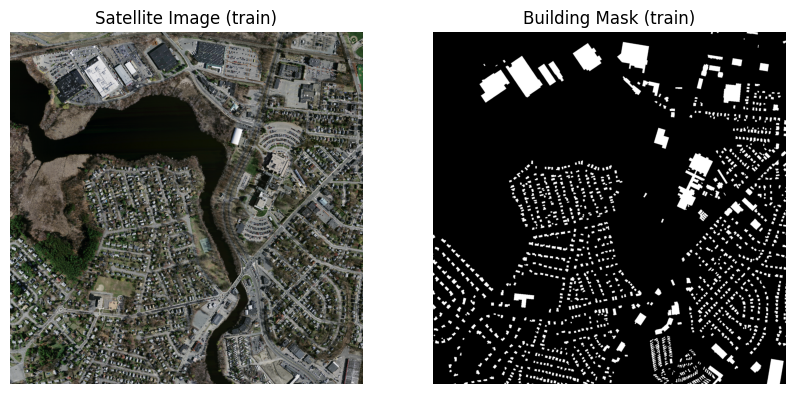

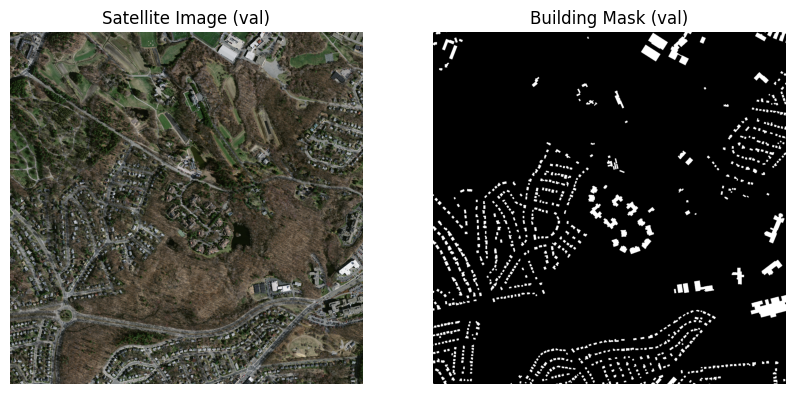

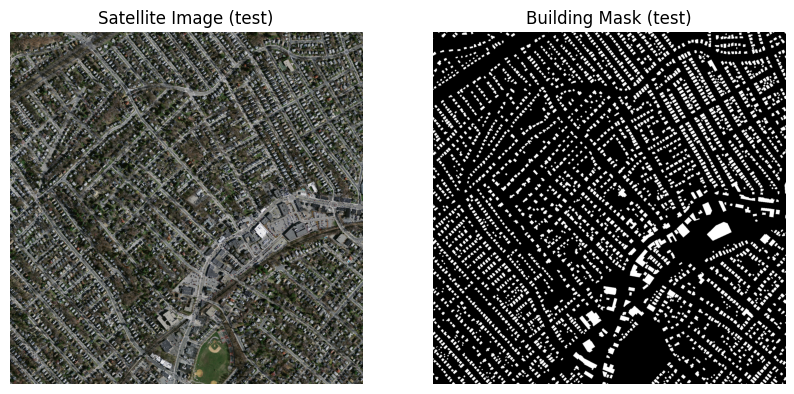

In [27]:
def explore_images(base_path):
    # Define the categories of the folders containing the images and their labels
    categories = ['train', 'train_labels', 'val', 'val_labels', 'test', 'test_labels']
    image_counts = {}
    
    # Iterate over each category to count the image files
    for category in categories:
        # Build the full path to the category folder
        path = os.path.join(base_path, category)
        # Count and store the number of files in each category
        image_counts[category] = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    
    # Print a summary of the image count for each folder
    print("Image count per folder:", image_counts)
    
    # Categories containing images for display
    sample_images = ['train', 'val', 'test']
    for category in sample_images:
        # Get the list of image files and labels
        images_list = os.listdir(os.path.join(base_path, category))
        labels_list = os.listdir(os.path.join(base_path, f"{category}_labels"))
        
        # Check if the image and label lists are not empty
        if images_list and labels_list:
            # Select the first image and label from the lists for display
            image_path = os.path.join(base_path, category, images_list[0])
            label_path = os.path.join(base_path, f"{category}_labels", labels_list[0])
            
            # Open the image and label with Pillow
            image = Image.open(image_path)
            label = Image.open(label_path)
            
            # Set up the display environment with Matplotlib
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(image)
            ax[0].set_title(f'Satellite Image ({category})')
            ax[0].axis('off')
            
            ax[1].imshow(label, cmap='gray')
            ax[1].set_title(f'Building Mask ({category})')
            ax[1].axis('off')
            
            # Display the images and labels
            plt.show()

# Get the current directory and use it to call the function
current_directory = os.getcwd()
explore_images(os.path.join(current_directory, 'MBDS/png'))

In [28]:
class SatelliteBuildingDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        """
        Initializes the SatelliteBuildingDataset class with specific directories for images and masks,
        and with optional transformations that can be applied to both images and masks.

        Args:
            image_dir (string): Directory containing all images.
            mask_dir (string): Directory containing all masks.
            transform_image (callable, optional): Optional transformation function to apply to images.
            transform_mask (callable, optional): Optional transformation function to apply to masks.
        """
        # Assign to instance variables the values of the parameters
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        # List all files in the image directory. It is assumed that each image has its corresponding mask.
        self.images = os.listdir(image_dir)

    def __len__(self):
        # Returns the total number of images in the dataset
        return len(self.images)

    def __getitem__(self, idx):
        # Build the full paths for the image and mask using the provided index
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])
        
        # Open the image and convert it to RGB color
        image = Image.open(img_name).convert("RGB")
        # Open the mask and convert it to grayscale so that it has a single channel
        mask = Image.open(mask_name).convert("L")  

        # Apply the specified transformations to the image and mask, if provided
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        # Return the processed image and mask
        return image, mask

In [29]:
def create_dataloaders(base_path, resize, batch_size=4):
    """
    Creates and returns dataloaders for training and validation datasets.
    
    Args:
        base_path (str): Base path where the data folders are located.
        resize (tuple): Dimensions to which all images and masks will be resized.
        batch_size (int, optional): Number of samples per batch. The default value is 4.
    """
    
    # Define transformations to apply to the images:
    # - Resize the images to the specified size.
    # - Convert the images to PyTorch tensors.
    # - Normalize the images using specified means and standard deviations.
    transform_image = Compose([
        Resize(resize),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Define transformations for the masks, which include resizing and conversion to tensor.
    # Masks generally do not require normalization.
    transform_mask = Compose([
        Resize(resize),
        ToTensor()
    ])

    # Build full paths to the training and validation image and mask directories
    train_dir = os.path.join(base_path, 'train')
    train_mask_dir = os.path.join(base_path, 'train_labels')
    val_dir = os.path.join(base_path, 'val')
    val_mask_dir = os.path.join(base_path, 'val_labels')
    
    # Create the training and validation datasets using the SatelliteBuildingDataset class
    train_dataset = SatelliteBuildingDataset(train_dir, train_mask_dir, transform_image, transform_mask)
    val_dataset = SatelliteBuildingDataset(val_dir, val_mask_dir, transform_image, transform_mask)

    # Create dataloaders for the training and validation datasets.
    # The training dataloader shuffles the data (shuffle=True) to improve training.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Return the training and validation dataloaders
    return train_loader, val_loader

In [30]:
# Assuming you are running this from the main directory of your project
base_path = os.getcwd()
base_path = os.path.join(base_path, 'MBDS/png')

In [31]:
# We create the model, as well as the loss function. 
# The model is of the U-Net type, with 4 encoder downsampling blocks and 4 decoder upsampling blocks.

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Double convolution block that applies two convolution layers with a batch normalization 
        and ReLU activation between them.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
        """
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        DownBlock in U-Net that includes a DoubleConv followed by max pooling 
        to reduce spatial dimension.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels after DoubleConv.
        """
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        """
        UpBlock in U-Net that performs upsampling and combines features
        from earlier layers through concatenation operation.

        Args:
            in_channels (int): Total number of input channels (sum of output channels from previous block and skip connection).
            out_channels (int): Number of output channels.
            up_sample_mode (str): Upsampling mode, 'conv_transpose' for ConvTranspose2d or 'bilinear' for bilinear interpolation.
        """
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels - out_channels, in_channels - out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
        """
        U-Net architecture for segmentation that includes descending and ascending paths with a bottleneck.

        Args:
            out_classes (int): Number of output classes (usually 1 for binary segmentation masks).
            up_sample_mode (str): Upsampling mode used in the ascent blocks.
        """
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        self.double_conv = DoubleConv(512, 1024)
        self.up_conv4 = UpBlock(1024 + 512, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(512 + 256, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(256 + 128, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x


class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        """
        Implementation of the Dice Loss, useful for comparing the similarity between two samples.

        Args:
            smooth (float): Value to prevent division by zero and smooth the result.
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)  # Convert logits to probabilities
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()                            
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)  
        
        return 1 - dice

In [32]:
# Fully Convolutional Neural Network

class FullyConvolutionalNetwork(nn.Module):
    def __init__(self, num_classes):
        super(FullyConvolutionalNetwork, self).__init__()
        
        # First convolutional layer with kernel size 12x12, stride of 4, and 64 output channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=12, stride=4, padding=1)
        
        # Second convolutional layer with kernel size 4x4, stride of 1 (default), and 112 output channels
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=112, kernel_size=4, padding=1)
        
        # Third convolutional layer with kernel size 3x3, stride of 1 (default), and 80 output channels
        self.conv3 = nn.Conv2d(in_channels=112, out_channels=80, kernel_size=3, padding=1)
        
        # Deconvolutional layer to upsample the feature map to 16x16
        self.deconv = nn.ConvTranspose2d(in_channels=80, out_channels=num_classes, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Apply first convolutional layer and activation function
        x = nn.functional.relu(self.conv1(x))
        
        # Apply second convolutional layer and activation function
        x = nn.functional.relu(self.conv2(x))
        
        # Apply third convolutional layer and activation function
        x = nn.functional.relu(self.conv3(x))
        
        # Upsample the feature map to 16x16 using the deconvolutional layer
        x = self.deconv(x)
        return x

# Example usage
num_classes = 2  # Replace with the number of classes in your specific task
# model = FullyConvolutionalNetwork(num_classes=num_classes)

# Example input tensor of size (batch_size, channels, height, width)
# Assuming batch_size = 1, channels = 3 (RGB), height and width = 80 to match the architecture's expected input dimensions
# input_tensor = torch.randn(1, 3, 80, 80)

# Forward pass through the model
# output = model(input_tensor)

# The output tensor will be of shape (batch_size, num_classes, 16, 16) representing class scores for each 16x16 pixel area
# print(output.shape)  # Expected shape: torch.Size([1, num_classes, 16, 16])


In [33]:
# Load the model
model = FullyConvolutionalNetwork(num_classes=num_classes)
# Check if CUDA is available and move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [34]:
# Test to ensure everything is functioning correctly
# Create an input tensor and move it to the same device
input_tensor = torch.rand((1, 3, 256, 256)).to(device)

# Perform the prediction
output_mask = model(input_tensor)
print(output_mask.shape)  # The output shape should be [1, 1, 256, 256], corresponding to the predicted mask

torch.Size([1, 2, 122, 122])


In [35]:
# We add the IoU as a metric to see how the model progresses and performs. 
# The training metric is Dice, but it's good to have more than one metric if possible.

def calculate_iou(outputs, masks):
    """
    Calcula el promedio de la métrica Intersección sobre Unión (IoU) entre las salidas del modelo y las máscaras verdaderas.

    Args:
        outputs: Salidas del modelo (logits).
        masks: Máscaras verdaderas (ground truth).

    Returns:
        Un valor flotante que representa el IoU promedio.
    """
    outputs = torch.sigmoid(outputs) > 0.5  # Convertir logits a predicciones binarias
    outputs = outputs.cpu().numpy().astype(np.uint8)  # Convertir a NumPy para cálculo
    masks = masks.cpu().numpy().astype(np.uint8)
    
    # Calcular IoU para cada par de salida y máscara
    ious = [jaccard_score(m.flatten(), o.flatten()) for m, o in zip(masks, outputs)]
    return np.mean(ious)

def weight_reset(m):
    """
    Reinicia los pesos de las capas convolucionales y lineales a sus valores iniciales.

    Args:
        m: Módulo de PyTorch (capa).
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [36]:
class SegmentationLoss(nn.Module):
    def __init__(self):
        super(SegmentationLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()  # This loss function expects class indices as the target

    def forward(self, inputs, targets):
        """
        Calculate the segmentation loss. It assumes that inputs are raw scores for each class (i.e., before softmax).

        Args:
            inputs (Tensor): Predictions from the model of shape (N, C, H, W), where
                             N is the batch size,
                             C is the number of classes,
                             H and W are the height and width of the predictions.
            targets (Tensor): Ground truth labels of shape (N, H, W), where each value is 0 <= targets[i] <= C-1

        Returns:
            Tensor: Calculated loss.
        """
        # Resize the input to match the target if necessary (this step may not be needed if your FCN outputs the correct size)
        # Note: This resizing is a simple method, you might want to use more sophisticated resizing to preserve output details.
        _, _, height, width = targets.size()
        inputs = nn.functional.interpolate(inputs, size=(height, width), mode='bilinear', align_corners=False)
        
        return self.criterion(inputs, targets)

# Usage example
loss_function = SegmentationLoss().to(device)


Training model with image size: (64, 64)


Epoch 1/2 Training:   0%|          | 0/35 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (5408) must match the size of tensor b (16384) at non-singleton dimension 0